<a href="https://colab.research.google.com/github/ZenaPoudel/Schiz_Detector/blob/main/Results/0_7_0_3_SchizophreniaDetection_without_skull_strip_MCIC_T1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount GDrive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# install libraries



In [2]:
pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 61.8 MB/s eta 0:00:00


In [3]:
pip install nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install pytorch-ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.1/264.1 KB 11.1 MB/s eta 0:00:00


# import libraries

In [5]:
import numpy as np
import pandas as pd
import random
import glob2
# import matplotlib.pyplot as plt 
# import nibabel.processing as nib_processing
# import nibabel.affines as nib_affines
import matplotlib.pyplot as plt
import torch
import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset, ArrayDataset
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    RandRotate90,
    Resize,
    ResizeWithPadOrCrop,
    Spacing,
    ScaleIntensity,
    NormalizeIntensity,
    Orientation, 
    LoadImage,
    SpatialResample,
    Lambda,
    AffineGrid,
    Resample,
    EnsureType
)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch

In [7]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, balanced_accuracy_score
from torch.nn.modules.loss import NLLLoss
import matplotlib.pyplot as plt

# memory, device and random seed


In [8]:
pin_memory = torch.cuda.is_available()
device = torch.device("cuda" ) if torch.cuda.is_available() else "cpu"

In [9]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

In [10]:
random_seed = 1 

In [11]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

# Hyperparameter

In [12]:
batch_size = 8
dropout = 0.3
max_epochs= 30
learning_rate = 0.0001


#Data Load

**#COBRE**

In [13]:
# cobre_T1 = glob2.glob('/content/drive/MyDrive/schizophrenia_data/COBRE/schizconnect_COBRE_images_16224/COBRE/**/anat/**/*_T1w.nii.gz', recursive = True)
# # cobre_T2 = glob2.glob('/content/drive/MyDrive/schizophrenia_data/COBRE/schizconnect_COBRE_images_16224/COBRE/**/anat/**/*_T2w.nii.gz', recursive = True)

In [14]:
# cobre_tsv_path = '/content/drive/MyDrive/schizophrenia_data/COBRE/schizconnect_COBRE_images_16224/COBRE/participants.tsv'

In [15]:
# cobre_participants = pd.read_csv(cobre_tsv_path,sep='\t')

In [16]:
# diagnosis = []
# for index, row in cobre_participants.iterrows():
#   if (row['dx'] == 'No_Known_Disorder'):
#     diagnosis.append(0)
#   elif (row['dx'] == 'Bipolar_Disorder'):
#     diagnosis.append(2)
#   else:
#     diagnosis.append(1)

# cobre_participants = pd.concat([cobre_participants, pd.DataFrame(diagnosis)], axis=1)
# cobre_participants.columns = ['study', 'participant_id','age', 'sex','dx','diagnosis']

In [17]:
# COBRE_healthy_subjects = []
# COBRE_schiz_subjects = []

In [18]:
# for index, row in cobre_participants.iterrows():
#     if (row['diagnosis'] == 1):
#         COBRE_schiz_subjects.append(row['participant_id'])
#     elif (row['diagnosis'] == 0):
#         COBRE_healthy_subjects.append(row['participant_id'])

In [19]:
# COBRE_healthy = []
# COBRE_schiz = []
# COBRE_healthy_labels = []
# COBRE_schiz_labels = []

# for C in cobre_T1:
#   if (any(ele in C for ele in COBRE_healthy_subjects)):
#       COBRE_healthy.append(C)
#       COBRE_healthy_labels.append(0)
#   elif (any(ele in C for ele in COBRE_schiz_subjects)):
#       COBRE_schiz.append(C)
#       COBRE_schiz_labels.append(1)

In [20]:
# print(len(COBRE_healthy))
# print(len(COBRE_schiz))

In [21]:
# COBRE_healthy_split = int(len(COBRE_healthy) * (1 - 0.3))
# COBRE_schiz_split = int(len(COBRE_schiz) * (1 - 0.3))

In [22]:
# print(COBRE_healthy_split)
# print(COBRE_schiz_split)

**#MCIC**

In [23]:
mcic_T1 = glob2.glob('/content/drive/MyDrive/schizophrenia_data/MCIC_/MCICShare/**/anat/*_T1w.nii', recursive = True)
# mcic_T2 = glob2.glob('/content/drive/MyDrive/schizophrenia_data/MCIC_/MCICShare/**/anat/*_T2w.nii', recursive = True)

In [24]:
mcic_tsv_path = '/content/drive/MyDrive/schizophrenia_data/MCIC_/MCICShare/participants.tsv'

In [25]:
mcic_participants = pd.read_csv(mcic_tsv_path,sep='\t')

In [26]:
mcic_participants['diagnosis'] = np.where(mcic_participants['dx']== 'No_Known_Disorder', 0, 1)

In [27]:
MCIC_healthy_subjects = []
MCIC_schiz_subjects = []

In [28]:
for index, row in mcic_participants.iterrows():
  if (row['diagnosis'] == 1):
      MCIC_schiz_subjects.append(row['participant_id'])
  else:
      MCIC_healthy_subjects.append(row['participant_id'])

In [29]:
MCIC_healthy = []
MCIC_schiz = []
MCIC_healthy_labels = []
MCIC_schiz_labels = []

In [30]:
for M in mcic_T1:
  if (any(ele in M for ele in MCIC_healthy_subjects)):
      MCIC_healthy.append(M)
      MCIC_healthy_labels.append(0)
  else:  
      MCIC_schiz.append(M)
      MCIC_schiz_labels.append(1)

In [31]:
print(len(MCIC_healthy))
print(len(MCIC_schiz))

264
306


In [32]:
MCIC_healthy_split = int(len(MCIC_healthy) * (1 - 0.3))
MCIC_schiz_split = int(len(MCIC_schiz) * (1 - 0.3))

In [33]:
print(MCIC_healthy_split)
print(MCIC_schiz_split)

184
214


**#BrainGluSchi**

In [34]:
# bgsc= glob2.glob('/content/drive/MyDrive/schizophrenia_data/unrepeated_bgsc_t1/**/*.nii.gz', recursive = True)

In [35]:
# bgsc_tsv_path = '/content/drive/MyDrive/schizophrenia_data/unrepeated_bgsc_t1/assessment_data/2079_Demographics_20220620.csv'

In [36]:
# bgsc_participants = pd.read_csv(bgsc_tsv_path,sep=',')

In [37]:
# diagnosis=[]

In [38]:
# for index, row in bgsc_participants.iterrows():
#   if (row['Subject Type'] == 'Old Control'):
#     diagnosis.append(0)
#   elif (row['Subject Type'] == 'Young Control'):
#     diagnosis.append(0)
#   elif (row['Subject Type'] == 'Control'):
#     diagnosis.append(0)
#   else:
#     diagnosis.append(1)

In [39]:
# bgsc_participants = pd.concat([bgsc_participants, pd.DataFrame(diagnosis)], axis=1)

In [40]:
# bgsc_healthy_subjects = []
# bgsc_schiz_subjects = []

In [41]:
# for index, row in bgsc_participants.iterrows():
#   if (row[0] == 1):
#     bgsc_schiz_subjects.append(row['Anonymized ID'])
#   elif(row[0] == 0):
#     bgsc_healthy_subjects.append(row['Anonymized ID'])

In [42]:
# bgsc_healthy = []
# bgsc_schiz = []
# bgsc_healthy_labels = []
# bgsc_schiz_labels = []

In [43]:
# for b in bgsc:
#   if (any(ele in b for ele in bgsc_healthy_subjects)):
#     bgsc_healthy.append(b)
#     bgsc_healthy_labels.append(0)
#   elif(any(ele in b for ele in bgsc_schiz_subjects)):    
#     bgsc_schiz.append(b)
#     bgsc_schiz_labels.append(1)

In [44]:
# print(len(bgsc_healthy))
# print(len(bgsc_schiz))

In [45]:
# bgsc_healthy_split = int(len(bgsc_healthy) * (1 - 0.3))
# bgsc_schiz_split = int(len(bgsc_schiz) * (1 - 0.3))

In [46]:
# print(bgsc_healthy_split)
# print(bgsc_schiz_split)


**#SRPBS** 

In [47]:
# srpbs_healthy = glob2.glob('/content/drive/MyDrive/schizophrenia_data/SRPBS_/srpbs_healthy/**/t1/*.nii', recursive = True)
# srpbs_schiz = glob2.glob('/content/drive/MyDrive/schizophrenia_data/SRPBS_/srpbs_schiz/**/t1/*.nii', recursive = True)


In [48]:
# srpbs_healthy_labels = []
# srpbs_schiz_labels = []

In [49]:
# for s in srpbs_healthy:
#   srpbs_healthy_labels.append(0)

# for s in srpbs_schiz:
#   srpbs_schiz_labels.append(1)

In [50]:
# print(len(srpbs_healthy))
# print(len(srpbs_schiz))

In [51]:
# srpbs_healthy_split = int(len(srpbs_healthy) * (1 - 0.3))
# srpbs_schiz_split = int(len(srpbs_schiz) * (1 - 0.3))

In [52]:
# print(srpbs_healthy_split)
# print(srpbs_schiz_split)

`

**#UCLA** {For Testing}

In [53]:
# ucla_healthy = glob2.glob('/content/drive/MyDrive/schizophrenia_data/UCLA/HEALTHY/**/anat/*_T1w.nii.gz', recursive = True)
# ucla_schiz = glob2.glob('/content/drive/MyDrive/schizophrenia_data/UCLA/SCHZ/**/anat/*_T1w.nii.gz', recursive = True)

In [54]:
# ucla_healthy_labels = []
# ucla_schiz_labels = []

In [55]:
# for u in ucla_healthy:
#   ucla_healthy_labels.append(0)

# for u in ucla_schiz:
#   ucla_schiz_labels.append(1)

In [56]:
# print(len(ucla_healthy))
# print(len(ucla_schiz))

# Transform

In [57]:
transforms = Compose([NormalizeIntensity(), EnsureChannelFirst(), Orientation(axcodes='RAS'), Spacing(pixdim=(2,2,2)), ResizeWithPadOrCrop(spatial_size=(99,99,99))])


# Training and validation Dataset and Dataloader

Images

In [58]:
# healthy_train = np.concatenate((MCIC_healthy[:MCIC_healthy_split], COBRE_healthy[:COBRE_healthy_split], bgsc_healthy[:bgsc_healthy_split], srpbs_healthy[:srpbs_healthy_split]))
# schiz_train = np.concatenate((MCIC_schiz[:MCIC_schiz_split], COBRE_schiz[:COBRE_schiz_split], bgsc_schiz[:bgsc_schiz_split], srpbs_schiz[:srpbs_schiz_split]))

# healthy_val = np.concatenate((MCIC_healthy[MCIC_healthy_split:], COBRE_healthy[COBRE_healthy_split:], bgsc_healthy[bgsc_healthy_split:], srpbs_healthy[srpbs_healthy_split:]))
# schiz_val = np.concatenate((MCIC_schiz[MCIC_schiz_split:], COBRE_schiz[COBRE_schiz_split:], bgsc_schiz[bgsc_schiz_split:], srpbs_schiz[srpbs_schiz_split:]))))

In [59]:
# healthy_train = np.concatenate((MCIC_healthy[:100], COBRE_healthy[:100], bgsc_healthy[:100], srpbs_healthy[:100]))
# schiz_train = np.concatenate((MCIC_schiz[:100], COBRE_schiz[:100], bgsc_schiz[:100], srpbs_schiz[:100]))

# healthy_val = np.concatenate((MCIC_healthy[100:140], COBRE_healthy[100:140], bgsc_healthy[100:140], srpbs_healthy[100:140]))
# schiz_val = np.concatenate((MCIC_schiz[100:140], COBRE_schiz[100:140], bgsc_schiz[100:140], srpbs_schiz[100:140]))

Labels

In [60]:
# healthy_train_labels = np.concatenate((MCIC_healthy_labels[:MCIC_healthy_split], COBRE_healthy_labels[:COBRE_healthy_split], bgsc_healthy_labels[:bgsc_healthy_split], srpbs_healthy_labels[:srpbs_healthy_split]))
# schiz_train_labels = np.concatenate((MCIC_schiz_labels[:MCIC_schiz_split], COBRE_schiz_labels[:COBRE_schiz_split], bgsc_schiz_labels[:bgsc_schiz_split], srpbs_schiz_labels[:srpbs_schiz_split]))

# healthy_val_labels = np.concatenate((MCIC_healthy_labels[MCIC_healthy_split:], COBRE_healthy_labels[COBRE_healthy_split:], bgsc_healthy_labels[bgsc_healthy_split:], srpbs_healthy_labels[srpbs_healthy_split:]))
# schiz_val_labels = np.concatenate((MCIC_schiz_labels[MCIC_schiz_split:], COBRE_schiz_labels[COBRE_schiz_split:], bgsc_schiz_labels[bgsc_schiz_split:], srpbs_schiz_labels[srpbs_schiz_split:]))))

In [61]:
# healthy_train_labels = np.concatenate((MCIC_healthy_labels[:100], COBRE_healthy_labels[:100], bgsc_healthy_labels[:100], srpbs_healthy_labels[:100]))
# schiz_train_labels = np.concatenate((MCIC_schiz_labels[:100], COBRE_schiz_labels[:100], bgsc_schiz_labels[:100], srpbs_schiz_labels[:100]))

# healthy_val_labels = np.concatenate((MCIC_healthy_labels[100:140], COBRE_healthy_labels[100:140], bgsc_healthy_labels[100:140], srpbs_healthy_labels[100:140]))
# schiz_val_labels = np.concatenate((MCIC_schiz_labels[100:140], COBRE_schiz_labels[100:140], bgsc_schiz_labels[100:140], srpbs_schiz_labels[100:140]))

Training dataset

In [62]:
train_healthy_ds = ImageDataset(image_files= MCIC_healthy[:MCIC_healthy_split], labels=MCIC_healthy_labels[:MCIC_healthy_split], image_only=True, transform=transforms)
train_schiz_ds = ImageDataset(image_files=MCIC_schiz[:MCIC_schiz_split], labels=MCIC_schiz_labels[:MCIC_schiz_split], image_only=True, transform=transforms)
train_ds = train_healthy_ds + train_schiz_ds 

Training Data Loader

In [63]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2,worker_init_fn=seed_worker, generator=g, pin_memory=pin_memory)

Vlidation dataset

In [64]:
val_healthy_ds = ImageDataset(image_files=MCIC_healthy[MCIC_healthy_split:], labels=MCIC_healthy_labels[MCIC_healthy_split:], image_only=True, transform=transforms)
val_schiz_ds = ImageDataset(image_files=MCIC_schiz[MCIC_schiz_split:], labels=MCIC_schiz_labels[MCIC_schiz_split:], image_only=True,  transform=transforms)
val_ds = val_healthy_ds + val_schiz_ds 

Validation Data Loader

In [65]:
val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=2, pin_memory=pin_memory)

# Testing Dataset and Dataloader

Testing Dataset

In [66]:
# test_healthy_ds = ImageDataset(image_files= ucla_healthy, labels=ucla_healthy_labels, image_only=True, transform=transforms)
# test_schiz_ds = ImageDataset(image_files=ucla_schiz , labels=ucla_schiz_labels, image_only=True, transform=transforms)
# test_ds = test_healthy_ds + test_schiz_ds 

Test Loader

In [67]:
# test_loader = DataLoader(test_ds, pin_memory=pin_memory)

#Define Model

In [68]:
model = nn.Sequential(
        nn.Conv3d(1, 32, [3,3,3], stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None),
        nn.ReLU(inplace=False),
        nn.Conv3d(32, 32, [3,3,3], stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None),
        torch.nn.ReLU(inplace=False),
        nn.MaxPool3d([3,3,3], stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False),
        nn.Dropout(p=dropout, inplace=False),
        nn.Conv3d(32, 64, [3,3,3], stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None),
        nn.ReLU(inplace=False),
        nn.Conv3d(64, 64, [3,3,3], stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None),
        torch.nn.ReLU(inplace=False),
        nn.MaxPool3d([3,3,3], stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False),
        nn.Dropout(p=dropout, inplace=False),
        nn.Flatten(start_dim=1, end_dim=- 1),
        nn.Linear(46656, 512, bias=True, device=None, dtype=None),
        nn.Dropout(p=dropout, inplace=False),
        nn.Linear(512, 2, bias=True, device=None, dtype=None),
        nn.Softmax(dim=1)
    )

if torch.cuda.is_available():
  model.cuda()

# Training and validation of model

In [69]:
loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
val_interval = 1
best_metric = -1
best_metric_epoch = -1
train_best_metric = -1
train_best_metric_epoch = -1
train_accuracy = -1
epoch_loss_values = []
epoch_train_accuracy_values = []
epoch_train_balace_accuracy_values=[]
epoch_train_precision_values = []
epoch_train_recall_values = []
epoch_train_specificity_values = []
epoch_train_F1_values = []
epoch_val_accuracy_values = []
epoch_val_balace_accuracy_values=[]
epoch_val_precision_values = []
epoch_val_recall_values = []
epoch_val_specificity_values = []
epoch_val_F1_values = []
# writer = SummaryWriter()
for epoch in range(max_epochs):
  y_pred = []
  y_true = []
  val_y_pred = []
  val_y_true = []
  print("-" * 10)
  print(f"epoch {epoch + 1}/{max_epochs}")
  model.train()
  epoch_loss = 0
  epoch_val_accuracy = 0
  epoch_val_precision = 0
  epoch_val_recall= 0
  epoch_val_F1 = 0
  step = 0
  for batch_data in train_loader:
    step += 1
    inputs, labe = batch_data[0].to(device), batch_data[1].to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    labels = []
    for i in labe:
      if i == 0:
        i=[1,0]
        labels.append(i)
      elif i == 1:
        i=[0,1]
        labels.append(i)
    label = np.array(labels)
    labels = torch.from_numpy(label)
    labels = labels.float().to(device)
    
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_len = len(train_ds) // train_loader.batch_size
    
    output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction


    labels = labe.data.cpu().numpy()
    y_true.extend(labels)
    
  epoch_loss /= step
  epoch_loss_values.append(epoch_loss)

  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

  acc = accuracy_score(y_true, y_pred)
  epoch_train_accuracy_values.append(acc)


  bal_acc= balanced_accuracy_score(y_true, y_pred)
  epoch_train_balace_accuracy_values.append(bal_acc)

  precision = precision_score(y_true, y_pred)
  epoch_train_precision_values.append(precision)

  recall= recall_score(y_true, y_pred)
  epoch_train_precision_values.append(recall)

  specificity = tn / (tn+fp)
  epoch_train_specificity_values.append(specificity)

  f1_score = (precision * recall * 2 )/ (precision +recall)

  if f1_score!=f1_score:
    f1_score = 0
  else: 
    f1_score =f1_score

  epoch_train_F1_values.append(f1_score)

  print(f"epoch {epoch + 1}, training, average loss: {epoch_loss:.4f}, accuracy: {acc:.4f}, balanced_Acc:{bal_acc:.4f}, precision: { precision:.4f}, recall: {recall:.4f}, F1: {f1_score:.4f}, specificity: {specificity:.4f}, auc score: {roc_auc_score(y_true, y_pred)}")

  if (epoch + 1) % val_interval == 0:
    model.eval()
    with torch.no_grad():
      num_correct = 0.0
      metric_count = 0
      val_step = 0
      for val_data in val_loader:
        val_step +=1
        val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
        val_outputs = model(val_images)

        val_output = (torch.max(torch.exp(val_outputs), 1)[1]).data.cpu().numpy()
        val_y_pred.extend(val_output) # Save Prediction


        val_labels = val_labels.data.cpu().numpy()
        val_y_true.extend(val_labels) # Save Truth
        
    vtn, vfp, vfn, vtp = confusion_matrix(val_y_true, val_y_pred).ravel()

    val_acc = accuracy_score(val_y_true, val_y_pred)
    epoch_val_accuracy_values.append(val_acc)


    val_bal_acc= balanced_accuracy_score(val_y_true, val_y_pred)
    epoch_val_balace_accuracy_values.append(val_bal_acc)

    val_precision = precision_score(val_y_true, val_y_pred)
    epoch_val_precision_values.append(val_precision)

    val_recall= recall_score(val_y_true, val_y_pred)
    epoch_val_precision_values.append(val_recall)

    val_specificity = vtn / (vtn+vfp)
    epoch_val_specificity_values.append(val_specificity)

    val_f1_score = (val_precision * val_recall * 2 )/ (val_precision + val_recall)

    if val_f1_score!=val_f1_score:
      val_f1_score = 0
    else: 
      val_f1_score =val_f1_score

    epoch_val_F1_values.append(val_f1_score)

    if val_f1_score > best_metric:
      best_metric = val_f1_score
      best_metric_epoch = epoch + 1
      torch.save(model.state_dict(), "best_metric_model_classification3d_array.pth")
      print("saved new validation best metric model")

    print(f"epoch {epoch + 1}, validation, confusion matrix:{(vtn, vfp, vfn, vtp)} accuracy: {val_acc:.4f}, balanced accuracy:{val_bal_acc:.4f} precision: { val_precision:.4f}, recall: {val_recall:.4f}, F1: {val_f1_score:.4f}, specificity: {val_specificity:.4f}, auc score: {roc_auc_score(val_y_true, val_y_pred)}")
  
print(f"Training completed, validation best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/30
epoch 1, training, average loss: 0.7215, accuracy: 0.4925, balanced_Acc:0.5086, precision: 0.5526, recall: 0.2944, F1: 0.3841, specificity: 0.7228, auc score: 0.5086093051605038


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-69-ece0b1317bdd>:135: RuntimeWarning: invalid value encountered in double_scalars
  val_f1_score = (val_precision * val_recall * 2 )/ (val_precision + val_recall)


saved new validation best metric model
epoch 1, validation, confusion matrix:(80, 0, 92, 0) accuracy: 0.4651, balanced accuracy:0.5000 precision: 0.0000, recall: 0.0000, F1: 0.0000, specificity: 1.0000, auc score: 0.5
----------
epoch 2/30
epoch 2, training, average loss: 0.6951, accuracy: 0.5000, balanced_Acc:0.5171, precision: 0.5688, recall: 0.2897, F1: 0.3839, specificity: 0.7446, auc score: 0.5171424217797642
saved new validation best metric model
epoch 2, validation, confusion matrix:(71, 9, 83, 9) accuracy: 0.4651, balanced accuracy:0.4927 precision: 0.5000, recall: 0.0978, F1: 0.1636, specificity: 0.8875, auc score: 0.49266304347826084
----------
epoch 3/30
epoch 3, training, average loss: 0.6828, accuracy: 0.6131, balanced_Acc:0.6002, precision: 0.6111, recall: 0.7710, F1: 0.6818, specificity: 0.4293, auc score: 0.6001879317350671
saved new validation best metric model
epoch 3, validation, confusion matrix:(54, 26, 31, 61) accuracy: 0.6686, balanced accuracy:0.6690 precision: 

# Plot Curve

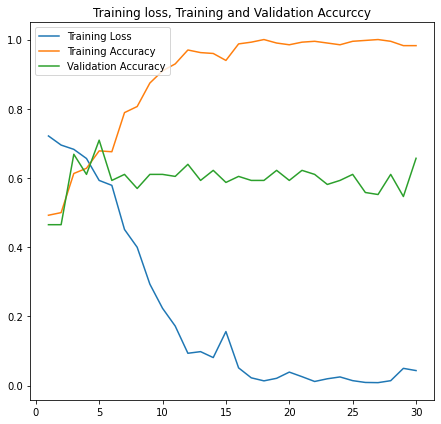

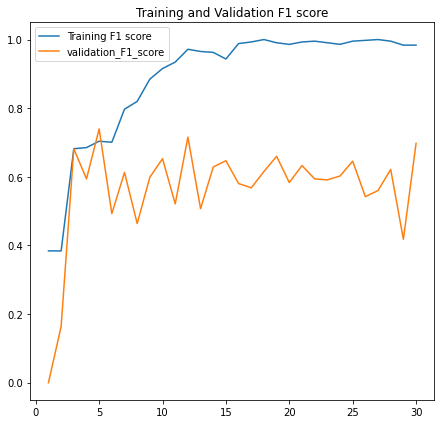

In [70]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

train_loss_acc = plt.figure('loss_acc', (12,6))
plt.subplot(1,2,1)
plt.title("Epoch Average Loss and accuracy")
x = [i+1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
x1 = [i+1 for i in range(len(epoch_train_accuracy_values))]
y1 = epoch_train_accuracy_values
x3 = [(i+1) for i in range(len(epoch_val_accuracy_values))]
y3 = epoch_val_accuracy_values
plt.plot(x, y, label='Training Loss')
plt.plot(x1,y1, label='Training Accuracy')
plt.plot(x3, y3, label='Validation Accuracy')
plt.title('Training loss, Training and Validation Accurccy')

plt.legend(loc='upper left')
plt.savefig('TrainingandValidationAccurccy.png')

F1_score = plt.figure('F1', (12,6))
plt.subplot(1,2,1)

plt.title("Epoch Average f1")

x2 = [i+1 for i in range(len(epoch_train_F1_values))]
y2 = epoch_train_F1_values

x4 = [i+1 for i in range(len(epoch_val_F1_values))]
y4 = epoch_val_F1_values


plt.plot(x2, y2, label='Training F1 score')
plt.plot(x4, y4, label='validation_F1_score')

plt.title('Training and Validation F1 score')

plt.legend(loc='upper left')
plt.savefig('TrainingandValidationF1.png')

#Testing

In [71]:
# state_dict_path='/content/best_metric_model_classification3d_array.pth'

In [72]:
# model.load_state_dict(torch.load(state_dict_path))

In [73]:
# test_y_pred = []
# test_y_true = []

In [74]:
# model.eval()
# with torch.no_grad():
#   num_correct = 0.0
#   metric_count = 0
#   val_step = 0
#   for test_data in test_loader:
#     test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
#     test_outputs = model(test_images)

#     test_output = (torch.max(torch.exp(test_outputs), 1)[1]).data.cpu().numpy()
#     test_y_pred.extend(test_output) # Save Prediction


#     test_labels = test_labels.data.cpu().numpy()
#     test_y_true.extend(test_labels) # Save Truth
    
# tn, fp, fn, tp = confusion_matrix(test_y_true, test_y_pred).ravel()

# test_acc = accuracy_score(test_y_true, test_y_pred)

# test_bal_acc= balanced_accuracy_score(test_y_true, test_y_pred)

# test_precision = precision_score(test_y_true, test_y_pred)

# test_recall= recall_score(test_y_true, test_y_pred)

# test_specificity = tn / (tn+fp)

# test_f1_score = (test_precision * test_recall * 2 )/ (test_precision + test_recall)

# if test_f1_score!=test_f1_score:
#   test_f1_score = 0
# else: 
#   test_f1_score =test_f1_score

# print(f"Testing, confusion matrix:{(tn, fp, fn, tp)} accuracy: {test_acc:.4f}, balanced accuracy:{test_bal_acc:.4f} precision: { test_precision:.4f}, recall: {test_recall:.4f}, F1: {test_f1_score:.4f}, specificity: {test_specificity:.4f}, auc score: {roc_auc_score(test_y_true, test_y_pred)}")